In [20]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import requests
import zipfile
import skimage.io as io
import skimage.transform
import cv2
import os
import shutil
import pandas as pd
import random
from tqdm import tqdm

# Generación del conjunto de datos de pinturas al óleo

Para la generación del conjunto de datos de pinturas se utiliza el dataset [Painter by Numbers - Kaggle](https://www.kaggle.com/competitions/painter-by-numbers), donde se pueden encontrar una gran cantidad de pinturas al óleo de diferentes artistas. 

In [94]:
# Load the metadata file for the dataset
file_path = 'paintings_complete_dataset_info/all_data_info.csv'
dataset_metadata = pd.read_csv(file_path)

# Show the first few rows of the dataset
dataset_metadata.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [98]:
styles = dataset_metadata['style'].unique()

print("Number of unique styles:", len(styles), "\n")
print("Styles:", styles)

Number of unique styles: 137 

Styles: ['Color Field Painting' 'Neoplasticism' 'Yamato-e' 'Ukiyo-e' 'Romanticism'
 'Surrealism' 'Northern Renaissance' 'Cloisonnism' 'Abstract Art'
 'Realism' 'Biedermeier' 'Symbolism' 'Baroque' 'Tenebrism' 'Cubism'
 'Mannerism (Late Renaissance)' 'Pointillism' 'Rococo' 'High Renaissance'
 'Fauvism' nan 'Early Renaissance' 'Magic Realism' 'Classicism'
 'Post-Impressionism' 'Art Nouveau (Modern)' 'Expressionism'
 'Impressionism' 'Japonism' 'Neoclassicism' 'Contemporary Realism'
 'Suprematism' 'Naïve Art (Primitivism)' 'Tachisme'
 'Ink and wash painting' 'Orphism' 'Luminism' 'Neo-Rococo' 'Orientalism'
 'Academicism' 'Tonalism' 'Op Art' 'Neo-Romanticism' 'Constructivism'
 'Dada' 'Neo-Expressionism' 'Abstract Expressionism' 'Proto Renaissance'
 'Lyrical Abstraction' 'Byzantine' 'Muralism' 'Art Informel'
 'Analytical\xa0Realism' 'Concretism' 'Art Brut' 'Pop Art'
 'Safavid Period' 'Regionalism' 'Futurism' 'Romanesque' 'American Realism'
 'Intimism' 'Synthetic 

In [112]:
genres = dataset_metadata['genre'].unique()

print("Number of unique genres:", len(genres), "\n")
print("Genres:", genres)

Number of unique genres: 43 

Genres: ['abstract' nan 'mythological painting' 'bird-and-flower painting'
 'cityscape' 'landscape' 'religious painting' 'marina' 'genre painting'
 'history painting' 'still life' 'animal painting' 'self-portrait'
 'illustration' 'allegorical painting' 'literary painting'
 'flower painting' 'portrait' 'figurative' 'interior' 'nude painting (nu)'
 'poster' 'symbolic painting' 'advertisement' 'design' 'panorama'
 'sketch and study' 'cloudscape' 'quadratura' 'caricature' 'capriccio'
 'veduta' 'battle painting' 'calligraphy' 'vanitas' 'pastorale'
 'wildlife painting' 'miniature' 'yakusha-e' 'tessellation' 'shan shui'
 'bijinga' 'urushi-e']


Podemos ver que existen las columnas `style` y `genre` que indican el estilo y el género de la pintura, respectivamente. Utilizaremos estas columnas para seleccionar las pinturas al óleo. Tomaremos las pinturas que cumplan con los siguientes criterios para filtrar las obras al óleo:

Estilos:

- Romanticism
- Realism
- Impressionism
- Neoclassicism
- Pointillism
- Fauvism
- Post-Impressionism

Géneros:

- portrait
- landscape
- still life
- history painting
- religious painting
- mythological painting
- genre painting
- allegorical painting
- nude painting (nu)
- figurative
- marina
- animal painting
- interior

**Nota:** Este enfoque se lleva a cabo porque sin información específica sobre los medios utilizados en cada pintura, nos basamos en estilos y géneros artísticos donde la pintura al óleo es más probable que sea el medio predominante. Al combinar los filtros de estilo y género, podemos seleccionar las pinturas al óleo de manera más precisa que una selección manual sin contar con el suficiente conocimiento especializado.

In [113]:
oil_painting_styles = [
    'Romanticism',
    'Realism',
    'Impressionism',
    'Neoclassicism',
    'Pointillism',
    'Fauvism',
    'Post-Impressionism'
]

oil_painting_genres = [
    'portrait',
    'landscape',
    'still life',
    'history painting',
    'religious painting',
    'mythological painting',
    'genre painting',
    'allegorical painting',
    'nude painting (nu)',
    'figurative',
    'marina',
    'animal painting',
    'interior'
]

# Filter the dataset to include only oil paintings with the criteria above
oil_paintings = dataset_metadata[
    (dataset_metadata['style'].isin(oil_painting_styles)) &
    (dataset_metadata['genre'].isin(oil_painting_genres))
].copy()

# Remove rows with missing values in the 'new_filename' column
oil_paintings = oil_paintings[oil_paintings['new_filename'].notna()]

Ya teniendo los nombres de las imágenes que corresponden a pinturas al óleo, se procede a separarlas en un conjunto diferente.

In [111]:
# Define the directory paths
original_images_dir = 'train_1/train_1'
target_images_dir = 'data/oil_painting/paintings'

# Create target directory if it doesn't exist
if not os.path.exists(target_images_dir):
    os.makedirs(target_images_dir)

not_found = 0
# Copy the filtered images to the target directory
print(f"Copying {len(oil_paintings)} oil paintings to {target_images_dir}...")
for _, row in oil_paintings.iterrows():
    filename = row['new_filename']
    src_path = os.path.join(original_images_dir, filename)
    dest_path = os.path.join(target_images_dir, filename)
    
    # Check if the source image exists before copying
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        not_found += 1

print("Copying completed.")
print(f"Images not found: {not_found}. Then, total images: {len(oil_paintings) - not_found}.")

# Define the directory paths
original_images_dir = 'train_2/train_2'
target_images_dir = 'data/oil_painting/paintings_3'

# Create target directory if it doesn't exist
if not os.path.exists(target_images_dir):
    os.makedirs(target_images_dir)

not_found = 0
# Copy the filtered images to the target directory
print(f"Copying {len(oil_paintings)} oil paintings to {target_images_dir}...")
for _, row in oil_paintings.iterrows():
    filename = row['new_filename']
    src_path = os.path.join(original_images_dir, filename)
    dest_path = os.path.join(target_images_dir, filename)
    
    # Check if the source image exists before copying
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        not_found += 1

print("Copying completed.")
print(f"Images not found: {not_found}. Then, total images: {len(oil_paintings) - not_found}.")

Copying 30749 oil paintings to data/oil_painting/paintings_3...
Copying completed.
Images not found: 27469. Then, total images: 3280.
Copying 30749 oil paintings to data/oil_painting/paintings_3...
Copying completed.
Images not found: 28262. Then, total images: 2487.


In [114]:
original_dirs = ['train_1/train_1', 'train_2/train_2']
target_images_dir = 'data/oil_painting/paintings'

# Create target directory if it doesn't exist
os.makedirs(target_images_dir, exist_ok=True)

not_found = 0
copied = 0
already_exists = 0

print(f"Copying oil paintings to {target_images_dir}...")

for _, row in oil_paintings.iterrows():
    filename = row['new_filename']
    dest_path = os.path.join(target_images_dir, filename)
    
    # Verify if the image already exists in the target directory
    if os.path.exists(dest_path):
        already_exists += 1
        continue
    
    # Copy the image from the original directories
    found = False
    for original_images_dir in original_dirs:
        src_path = os.path.join(original_images_dir, filename)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
            copied += 1
            found = True
            break
    if not found:
        not_found += 1

print("Copying completed.")
print(f"Total of copied images: {copied}.")
print(f"Total of images not found: {not_found}.")

Copying oil paintings to data/oil_painting/paintings_3...
Copying completed.
Total of copied images: 5767.
Total of images not found: 24982.


Es importante notar que el dataset ofrece la posibilidad de descargar las imágenes en diferentes lotes. Para este caso, se descargaron los comprimidos `train_1` y `train_2` que contienen imágenes suficientes para el entrenamiento del modelo. A continuación, se muestran ejemplos de pinturas al óleo que se encuentran en el dataset.

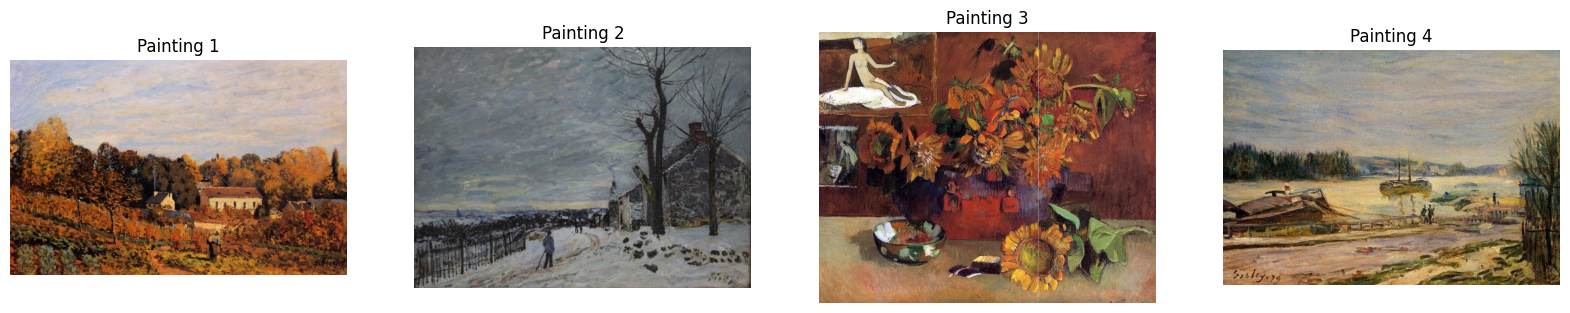

In [130]:
image_files = os.listdir(target_images_dir)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(target_images_dir, image_files[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        ax.imshow(img_rgb)
        ax.set_title(f'Painting {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

In [115]:
# Show the total number of images for the oil painting dataset
total_images = len(os.listdir(target_images_dir))

print(f"Total number of images in the oil painting dataset: {total_images}")

Total number of images in the oil painting dataset: 5767


Finalmente, el conjunto de imágenes de pinturas al óleo tiene un total de 5767.

# Generación del conjunto de datos de fotografías

Para la generación del conjunto de datos de fotografías se utilizará una combinación de un dataset de fotografías de paisajes [Landscape pictures](https://www.kaggle.com/datasets/arnaud58/landscape-pictures) y el conocido dataset [COCO](https://cocodataset.org/#home) que contiene una gran cantidad de imágenes de diferentes categorías.

## Dataset de paisajes

Se descarga el dataset directamente de Kaggle.

In [117]:
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/arnaud58/landscape-pictures

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  620M  100  620M    0     0  3683k      0  0:02:52  0:02:52 --:--:-- 3813k0  0:02:52  0:02:06  0:00:46 3818k


Se descomprime el dataset en un directorio específico.

In [120]:
zip_file_path = 'archive.zip'
target_images_dir = 'data/oil_painting/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_images_dir)
    
print("Content images extracted to:", target_images_dir)
print(f"Total number of content images: {len(os.listdir(target_images_dir))}")

Content images extracted to: data/oil_painting/content_3
Total number of content images: 4319


A continuación, se muestran 4 imágenes del conjunto recién creado.

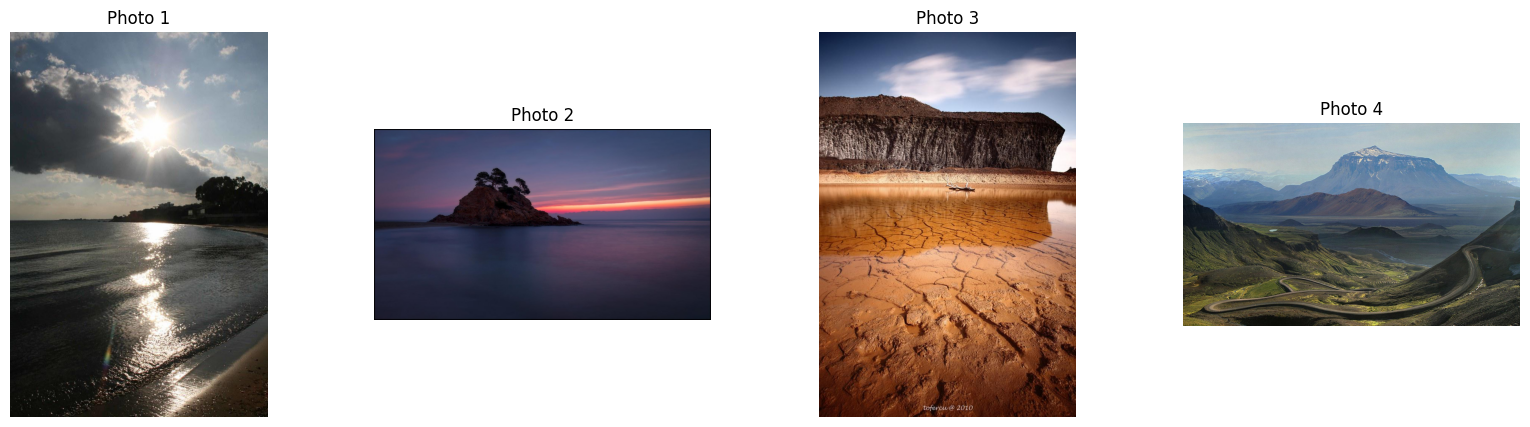

In [126]:
image_files = os.listdir(target_images_dir)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(target_images_dir, image_files[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        ax.imshow(img_rgb)
        ax.set_title(f'Photo {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

## Dataset COCO

En este caso, se utilizará la API de COCO para descargar las imágenes.

In [16]:
coco_annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
coco_images_base_url = 'http://images.cocodataset.org/zips/'
annotations_dir = 'coco_annotations'
images_dir = 'images'
output_dir = 'data/coco_content'
num_images = 1500

Es necesario descargar las anotaciones para posteriormente descargar las imágenes.

In [17]:
if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)
    print("Downloading COCO annotations...")
    response = requests.get(coco_annotations_url, stream=True)
    zip_path = os.path.join(annotations_dir, "annotations_trainval2017.zip")
    
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
            
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(annotations_dir)
    os.remove(zip_path)
    print("Annotations downloaded and extracted.")
else:
    print("Annotations already present.")

Annotations already present.


Ahora se procede a descargar las imágenes y guardarlas en un directorio específico.

In [5]:
# Load the annotations json file
annotations_file = os.path.join(annotations_dir, "annotations", "instances_train2017.json")
if not os.path.exists(annotations_file):
    print("Annotations file not found. Please download annotations first.")

coco = COCO(annotations_file)

loading annotations into memory...
Done (t=13.95s)
creating index...
index created!


In [18]:
# Get image ids for different categories
categories = ['person', 'outdoor', 'indoor', 'plant', 'food', 'furniture', 'chair', 'dining table', 'vase']

img_ids = []
for category in categories:
    cat_ids = coco.getCatIds(catNms=[category])
    img_ids.extend(coco.getImgIds(catIds=cat_ids))

# Remove duplicates and select a subset
img_ids = list(set(img_ids))
selected_img_ids = random.sample(img_ids, num_images)

In [21]:
# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save selected images with a progress bar
print(f"Saving {num_images} content images...")

for img_id in tqdm(selected_img_ids, desc="Downloading images"):
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']
    image = io.imread(img_url)
    output_path = os.path.join(output_dir, img_info['file_name'])
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
print(f"Content images saved to {output_dir}.")
print(f"Total number of content images: {len(os.listdir(output_dir))}")

Saving 1500 content images...


Content images saved to data/coco_content.
Total number of content images: 1500


Una vez descargadas las imágenes, se procede a mostrar 4 imágenes del conjunto recién creado.

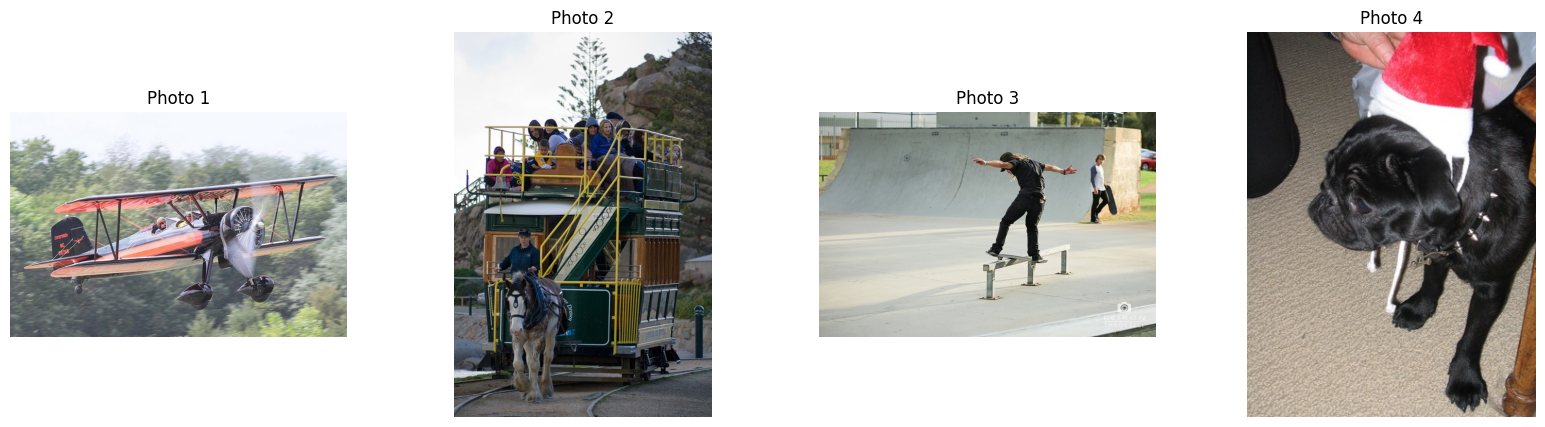

In [23]:
image_files = os.listdir(output_dir)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(output_dir, image_files[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        ax.imshow(img_rgb)
        ax.set_title(f'Photo {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

Ahora se procede a combinar los conjuntos de paisajes y COCO para obtener un conjunto nuevo.

In [ ]:
target_images_dir = 'data/oil_painting/content'

for filename in os.listdir(output_dir):
    source_path = os.path.join(output_dir, filename)
    destination_path = os.path.join(target_images_dir, filename)
    shutil.move(output_dir, target_images_dir)
    shutil.remove(output_dir)